The objective of this project is to develop a DCGAN capable of generating realistic-looking handwritten digits. The well-known MNIST handwritten digits dataset is used for this purpose. The implementation is carried out using Keras, and the training is performed on a Google Colab environment with a T4 GPU.

In [11]:
#Importing packages
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np
import os

from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd

In [12]:
#Linking Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Considering the limited training resources available, training is done only on a single digit. This function helps isolate all examples that are labelled as '8'.

In [13]:
#Function to isolate single digit
def loads(classes, x, y):
    x_s = None
    for i, c in enumerate(classes):
        indices = np.squeeze(np.where(y == c))
        x_c = x[indices]
        if i == 0:
            x_s = np.array(x_c)
        else:
            x_s = np.concatenate([x_s, x_c], axis=0)
    return x_s

The MNIST dataset consists of 70,000 images of handwritten digits (0-9), with 60,000 for training and 10,000 for testing. Each image is 28x28 pixels in grayscale. This dataset is widely used for benchmarking image processing and machine learning algorithms due to its simplicity and standardized format.

In [14]:
#Importing plotting functions
import plot
#Importing and Normalising data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
#Loading subset for digit 8
x_train  = loads([8], x_train, y_train)
x_test  = loads([8], x_test, y_test)
#Creating a single DF to store all
x = np.concatenate([x_train, x_test], axis = 0)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
x = np.concatenate([x_train, x_test], axis = 0)

The discriminator was designed first, inspired by the original 2015 DCGAN paper. It uses LeakyReLU activation functions for the hidden layers, which helps prevent the dying ReLU problem and allows the network to learn better. For the final layer, a sigmoid activation function is used to perform binary classification, distinguishing between real and generated images.

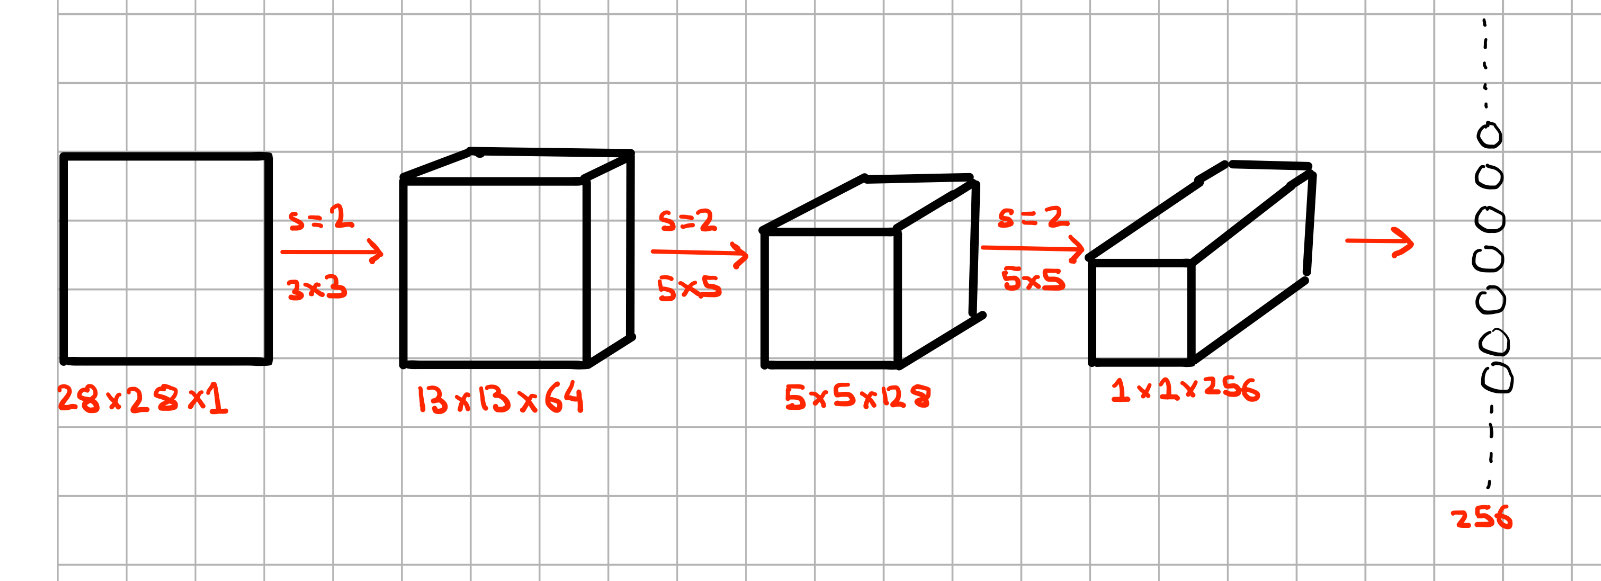

In [15]:
discriminator = tf.keras.models.Sequential([

    #Block 1
    tf.keras.layers.Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    #Block 2
    tf.keras.layers.Conv2D(128, 5, strides=2),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    #Block 3
    tf.keras.layers.Conv2D(256, 5, strides=2),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    #1D layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
#Backprop
opt = tf.keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1 = 0.5)
#Compile
discriminator.compile(loss='binary_crossentropy', optimizer = opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        640       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 13, 13, 64)        0         
                                                                 
 batch_normalization_7 (Bat  (None, 13, 13, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 5, 5, 128)         0         
                                                                 
 batch_normalization_8 (Bat  (None, 5, 5, 128)         512       
 chNormalization)                                     

The generator, designed to counter the discriminator, consists of transposed convolutional layers to upscale random noise into 28x28 images. It uses ReLU activation in hidden layers and a sigmoid activation function in the final layer to match the normalized pixel range of the MNIST dataset.

In [16]:
generator = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Dense(256, activation='relu', input_shape=(1, )),
    tf.keras.layers.Reshape((1,1,256)),
    #Block 2
    tf.keras.layers.Conv2DTranspose(256, 5, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    #Block 3
    tf.keras.layers.Conv2DTranspose(128, 5, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    #Block 4
    tf.keras.layers.Conv2DTranspose(64, 5,strides = 2, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    #Block 5
    tf.keras.layers.Conv2DTranspose(32, 5, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    #Block 6
    tf.keras.layers.Conv2DTranspose(1, 4, activation ='sigmoid'),

])
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               512       
                                                                 
 reshape_1 (Reshape)         (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 5, 5, 256)         1638656   
 Transpose)                                                      
                                                                 
 batch_normalization_10 (Ba  (None, 5, 5, 256)         1024      
 tchNormalization)                                               
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 9, 9, 128)         819328    
 Transpose)                                                      
                                                      

To create the GAN, I defined an input layer that feeds into the generator. The generator's output is then passed to the discriminator. This composite model, consisting of both the generator and discriminator, is trained end-to-end to optimize the generator's ability to produce realistic images. Initially, the discriminator is set to not be trainable to ensure only the generator's weights are updated during the first pass.

In [17]:
#Creating the GAN
input_layer = tf.keras.layers.Input(shape=(1,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)
gan = tf.keras.models.Model(
    input_layer,
    disc_out
)
#Disc is not trained in first pass
discriminator.trainable = False
#Compile
gan.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         2717025   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 1027073   
                                                                 
Total params: 3744098 (14.28 MB)
Trainable params: 2716065 (10.36 MB)
Non-trainable params: 1028033 (3.92 MB)
_________________________________________________________________


Lastly I made a training loop has for the entire GAN. First only the discriminator is trained. Its training is always done on a equal mixture of random noise and real examples, initially it is much better than the discriminator. Then the discriminator is trained seperately, its outputs are mostly noise at first and cannot fool the discriminator. But as iterations pass, the generator gets better at its job and can create images that the discriminator has a hard time fooling. They make each other better.

1/1 [==============================] - 0s 39ms/step


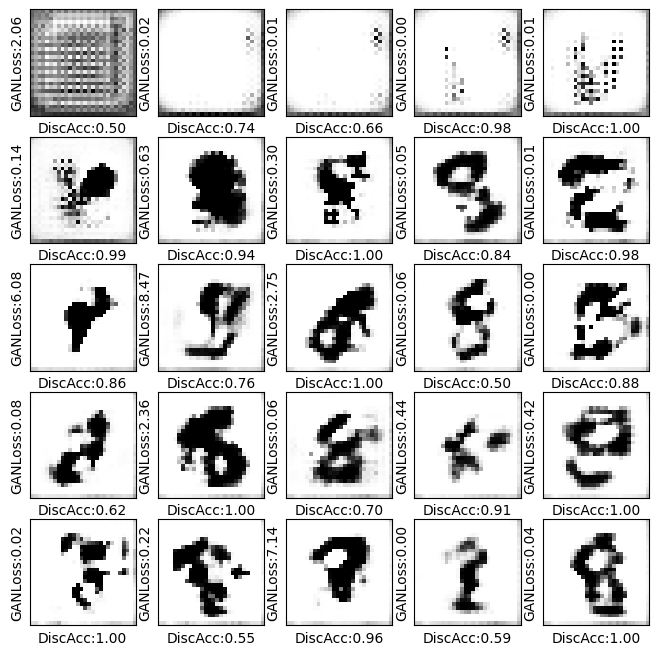

In [18]:
#Plotter
dp = plot.DynamicPlot(plt, 5, 5, (8,8))
#Important variables
epochs = 25
batch_size = 128
steps_per_epoch = int(2*x.shape[0]/batch_size)
#TrainingLoop
for e in range(0, epochs):
    dp.start_of_epoch(e) #Plot initial
    for step in range(0, steps_per_epoch):
        #One half of examples is real
        true_examples = x[int(batch_size/2)*step:int(batch_size/2)*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))
        #Other half is from generator
        noise = np.random.randn(int(batch_size/2),1)
        gen_examples = generator.predict(noise)
        #Final is:
        x_batch = np.concatenate([gen_examples, true_examples], axis = 0)
        #Creating fake labels and combining with real
        y_batch = np.array([0]*int(batch_size/2) + [1]*int(batch_size/2))
        #Shuffle both similiarly
        indices = np.random.choice(range(batch_size), batch_size, replace = False)
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        #Discriminator trained seperately initially
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        #Now only training the generator of GAN
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1))) #Trying to fool disc
        #Understanding the accuracy
        _, acc = discriminator.evaluate(x_batch, y_batch, verbose = False)
    noise = np.random.randn(1,1)
    gen_image= generator.predict(noise)[0]
    #Plotting each generated at end of epoch
    gen_image = np.reshape(gen_image, (28,28))
    dp.end_of_epoch(gen_image, 'binary', 'DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))

Training the GAN to generate the digit '8' showed significant improvements over time. Initially, the generated image of '8' was unclear and lacked detail. However, as training progressed, the image gradually became more defined and realistic. By the end of the training, the generator produced a well-defined and accurate image of '8'. 